# Fast Bernoulli: Benchmark Python

In this notebooks we will measure performance of generating sequencies of Bernoulli-distributed random varibales in Python without and within LLVM JIT compiler. The baseline generator is based on top of expression `random.uniform() < p`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from random import random
from typing import List

In [3]:
from bernoulli import LLVMBernoulliGenerator, PyBernoulliGenerator
from tqdm import tqdm

## Benchmarking

As it was mentioned above, the baseline generator is just thresholding a uniform-distributed random variable.

In [4]:
class BaselineBernoulliGenerator:
    
    def __init__(self, probability: float, tolerance: float = float('nan'), seed: int = None):
        self.prob = probability

    def __call__(self, nobits: int = 32):
        return [int(random() <= self.prob) for _ in range(nobits)]

Here we define some routines for benchmarking.

In [5]:
def benchmark(cls, nobits_list: List[int], probs: List[float], tol: float = 1e-6) -> np.ndarray:
    timings = np.empty((len(probs), len(nobits_list)))
    with tqdm(total=timings.size, unit='bench') as progress:
        for i, prob in enumerate(probs):
            generator = cls(prob, tol)
            for j, nobits in enumerate(nobits_list):
                try:
                    timing = %timeit -q -o generator(nobits)
                    timings[i, j] = timing.average
                except Exception as e:
                    # Here we catch the case when number of bits is not enough 
                    # to obtain desirable precision.
                    timings[i, j] = float('nan')
                progress.update()
    return timings

The proposed Bernoulli generator has two parameters. The first one is well-known that is probability of success $p$. The second one is precision of quantization.

In [6]:
NOBITS = [1, 2, 4, 8, 16, 32]
PROBAS = [1 / 2 ** n for n in range(1, 8)]

Now, start benchmarking!

In [7]:
baseline = benchmark(BaselineBernoulliGenerator, NOBITS, PROBAS)

100%|██████████| 42/42 [05:07<00:00,  6.98s/bench]

In [8]:
py = benchmark(PyBernoulliGenerator, NOBITS, PROBAS)

100%|██████████| 42/42 [02:54<00:00,  6.58s/bench]

In [9]:
llvm = benchmark(LLVMBernoulliGenerator, NOBITS, PROBAS)

100%|██████████| 42/42 [02:31<00:00,  3.01s/bench]

Multiplication by factor $10^6$ corresponds to changing units from seconds to microseconds.

In [10]:
baseline *= 1e6
py *= 1e6
llvm *= 1e6

Save timings for the future.

In [11]:
np.save('../data/benchmark-data-baseline.npy', baseline)
np.save('../data/benchmark-data-py.npy', py)
np.save('../data/benchmark-data-llvm.npy', llvm)

## Visualization

On the figures below we depics how timings (or bitrate) depends on algorithm parameters.

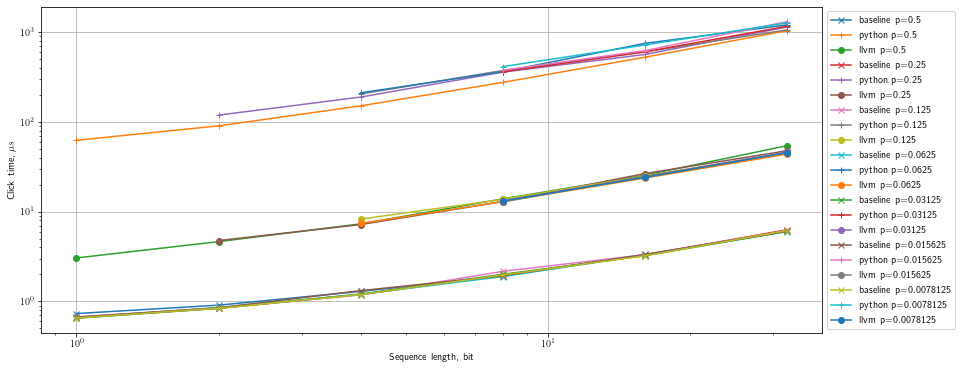

In [12]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 1, 1)
ax.grid()

for i, proba in enumerate(PROBAS):
    ax.loglog(NOBITS, baseline[i, :], '-x',label=f'baseline p={proba}')
    ax.loglog(NOBITS, py[i, :], '-+',label=f'python p={proba}')
    ax.loglog(NOBITS, llvm[i, :], '-o',label=f'llvm p={proba}')
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Sequence length, bit')
ax.set_ylabel('Click time, $\mu s$')

plt.show()

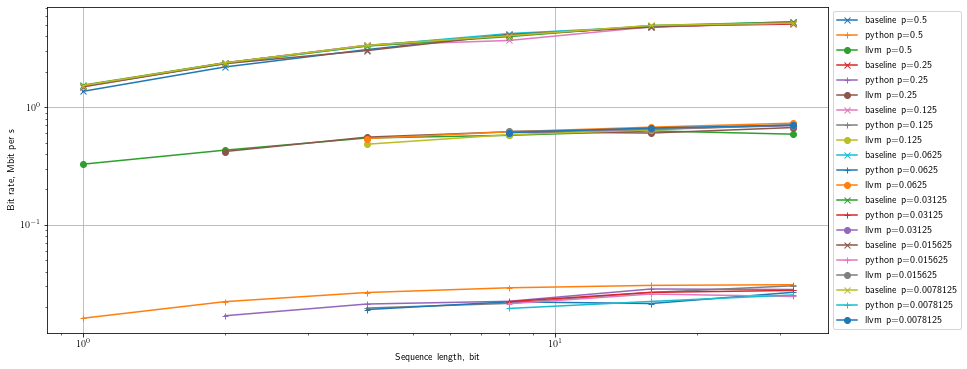

In [13]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 1, 1)
ax.grid()

for i, proba in enumerate(PROBAS):
    ax.loglog(NOBITS, NOBITS / baseline[i, :], '-x',label=f'baseline p={proba}')
    ax.loglog(NOBITS, NOBITS / py[i, :], '-+',label=f'python p={proba}')
    ax.loglog(NOBITS, NOBITS / llvm[i, :], '-o',label=f'llvm p={proba}')
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Sequence length, bit')
ax.set_ylabel('Bit rate, Mbit per s')

plt.show()

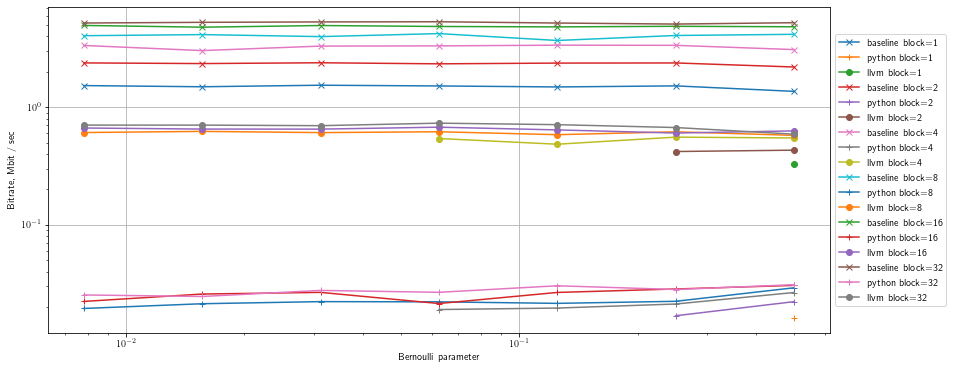

In [14]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 1, 1)
ax.grid()

for j, nobits in enumerate(NOBITS):
    ax.loglog(PROBAS, nobits / baseline[:, j], '-x',label=f'baseline block={nobits}')
    ax.loglog(PROBAS, nobits / py[:, j], '-+',label=f'python block={nobits}')
    ax.loglog(PROBAS, nobits / llvm[:, j], '-o',label=f'llvm block={nobits}')
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Bernoulli parameter')
ax.set_ylabel('Bitrate, Mbit / sec')

plt.show()

## Comments and Discussions

On the figures above one can see that direct implementation of the algorithm does not improve bitrate. Also, we can see that the statement is true for implementaion with LLVM as well as without LLVM. This means that overhead is too large.

Nevertheless, the third figure is worth to note that bitrate scales note very well for baseline generator. The bitrate of baseline drops dramatically while the bitrates of the others decrease much lesser.

Such benchmarking like this has unaccounted effects like different implementation levels (IR and Python), expansion of bit block to list of bits, overhead of Python object system.